Firstly, we try to find some feature points.

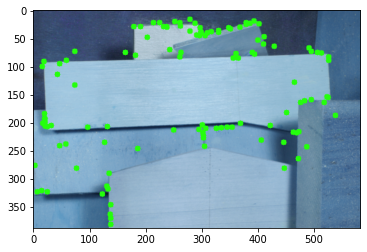

In [29]:
!pip install opencv-contrib-python==3.4.0.12
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import euclidean

# load two images
img1 = cv2.imread("./frame07.png")
img2 = cv2.imread("./frame08.png")

#Find the feature points
sift = cv2.xfeatures2d.SIFT_create()
kp1_SIFT, desc1_SIFT = sift.detectAndCompute(img1, None)
features = [feature.pt for feature in kp1_SIFT]
for feature in features:
    x,y = feature
    x = int(x)
    y = int(y)
    cv2.circle(img1,(x,y),5,(36,255,12),-1)

plt.imshow(img1, 'gray')

Then, blur both images with 2D Gaussian with sigma = 3

In [26]:
#blur the image
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
blur1 = cv2.GaussianBlur(gray1,(3,3),5) #set lambda to 3 can give us better corners.
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
blur2 = cv2.GaussianBlur(gray2,(3,3),5)

Then, try to find the motion vector by Lucas-Kanade construction.

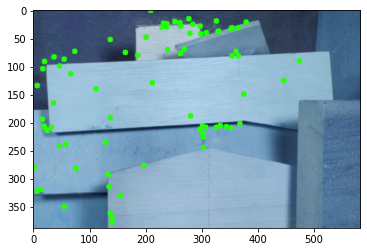

In [30]:
#First, find the gradient corresponding to x and y
Ix = np.gradient(blur1)[0]
Iy = np.gradient(blur1)[1]
#set the window size and find the elements in the matrix in Lucas-Kanade equation for every corner
window_size = 3
k = window_size // 2
for feature in features:
  x, y = feature
  x = int(x)
  y = int(y)
  #find all useful points in the window
  if x+k+1<blur1.shape[0] and y+k+1<blur1.shape[1]:
    use_Ix = Ix[x-k:x+k+1, y-k:y:k+1]
    use_Iy = Iy[x-k:x+k+1, y-k:y:k+1]
    use_img1 = blur1[x-k:x+k+1, y-k:y:k+1]
    use_img2 = blur2[x-k:x+k+1, y-k:y:k+1]
    
    #find the matrix in the left side
    IxIy = np.sum(np.multiply(use_Ix, use_Iy))
    Ix2 = np.sum(np.multiply(use_Ix, use_Ix))
    Iy2 = np.sum(np.multiply(use_Iy, use_Iy))
    left_matrix = np.array([[Ix2, IxIy], [IxIy, Iy2]])

    #find the matrix in the right side
    difference = use_img1 - use_img2
    difference_blur = cv2.GaussianBlur(difference, (5, 5), 10) #blur the derivatives in time
    right_matrix = np.array([[np.sum(np.multiply(difference_blur, use_Ix))], [np.sum(np.multiply(difference_blur, use_Iy))]])

    left_inverse = np.linalg.pinv(left_matrix)
    motion = np.dot(left_inverse, right_matrix)
    vx = motion[0][0]
    vy = motion[1][0]
    
    #here is the point that predicted by our motion vector. circle it in the original picture
    cv2.circle(img2,(int(x+vx),int(y+vy)),5,(36,255,12),-1)
plt.imshow(img2, 'gray')